# Correcting both bit-flip and phase-flip errors

This notebook implements the quantum circuit to recover a qubit from both bit flip and phase flip errors, using Shor's 9-quibts encoding.

## Importing needed modules

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer

## Three qubit encoding

Because of the no cloning theorem we cannot copy a qubit to add redundancy like we would do in classical computing. What we can do instead is implementing the following encoding:<br><br>
<center>
$|\psi\rangle =  \alpha|0\rangle + \beta|1\rangle \rightarrow \frac{\alpha}{\sqrt{8}}(|000\rangle + |111\rangle)^\otimes 3 + \frac{\beta}{\sqrt{8}}(|000\rangle - |111\rangle)^\otimes 3$
</center>


## Inizializing the circuit

For the circuit we need three qubits for the econding and two auxiliary qubits that will be used to detect if the bit flip occured and in which qubit.

In [7]:
q_enc_b1 = QuantumRegister(3, "enc_block_1")
q_anc_b1 = QuantumRegister(3, "anc_block_1")
q_enc_b2 = QuantumRegister(3, "enc_block_1")
q_anc_b2 = QuantumRegister(3, "anc")
q_enc_b3 = QuantumRegister(3, "enc")
q_anc_b3 = QuantumRegister(3, "anc")

qc = QuantumCircuit()

for reg in [q_enc_b1, q_anc_b1, q_enc_b2, q_anc_b2, q_enc_b3, q_anc_b3]:
    qc.add_register(reg)

qc.barrier()
qc.draw(output="mpl")

CircuitError: 'register name "enc" already exists'

## Implementing the encoding

The first qubit is the qubit we want to encode is in the first qubit. The initial state is:<br><br>
$(\alpha|0\rangle + \beta|1\rangle)|0\rangle|0\rangle =  \alpha|000\rangle + \beta|100\rangle$
<br><br>
After the first CNOT gate it becomes:<br><br>
$\alpha|000\rangle + \beta|110\rangle$
<br><br>
After the second CNOT gate it becomes:<br><br>
$\alpha|000\rangle + \beta|111\rangle$
<br><br>
which is the encoding we wanted.


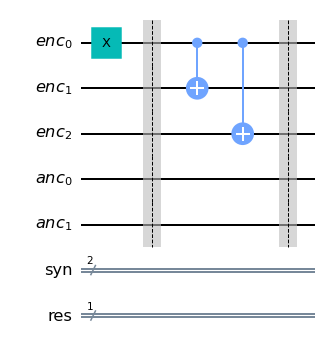

In [68]:
qc.cx(qe[0], qe[1])
qc.cx(qe[0], qe[2])

qc.barrier()

qc.draw(output="mpl")